In [13]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [14]:
global sample_n # 样本数量
sample_n = 10
global poly_degree # 多项式次数
poly_degree = 9

In [15]:
'''
    生成样本数据
    样本x为[0,0.9]上均匀的sample_n个点
    样本y值为sin(2Πx)的值，再加上均值为mu，标准差为sigma的高斯噪声
'''
def genData(mu, sigma):
    train_x = np.arange(0, 1, 1 / sample_n)
    gauss_noise = np.random.normal(mu, sigma, sample_n)
    train_y = np.sin(train_x * 2 * np.pi) + gauss_noise
    return train_x, train_y

In [16]:
'''
    求得损失函数E(w)
    E(w) = 1/2 * (Xw - Y)^{T} . (Xw - Y)
'''
def loss(train_x, train_y, w):
    X = genMatrixX(train_x)
    Y = train_y.reshape((sample_n, 1))
    temp = X.dot(w) - Y
    loss = 1/2 * np.dot(temp.T, temp)
    return loss

In [17]:
'''
    获取X矩阵
    由于生成的得到的样本数据是一维向量，要预处理成为矩阵X(维度为sample_n * (poly_degree + 1))
'''
def genMatrixX(train_x):
    X = np.zeros((sample_n, poly_degree + 1))
    for i in range(sample_n):
        row_i = np.ones(poly_degree + 1) * train_x[i]
        nature_row = np.arange(0, poly_degree+1)
        row_i = np.power(row_i, nature_row)
        X[i] = row_i
    return X

In [18]:
'''
    调用numpy.polyfit()拟合数据
'''
def np_polyfit(train_x, train_y):
    w = np.polyfit(train_x, train_y, poly_degree)
    poly = np.poly1d(w)
    return poly

In [19]:
'''
    不加惩罚项，令损失函数导数等于0，求此时的w
'''
def lsm_loss(train_x, train_y):
    X = genMatrixX(train_x)
    Y = train_y.reshape((sample_n, 1))
    w = np.linalg.inv(np.dot(X.T, X)).dot(X.T).dot(Y)
    poly = np.poly1d(w[::-1].reshape(poly_degree + 1))
    return poly

In [20]:
'''
    加惩罚项，系数为lam，令损失函数导数等于0，求此时的w
'''
def lsm_punished_loss(train_x, train_y, lam):
    X = genMatrixX(train_x)
    Y = train_y.reshape((sample_n, 1))
    w = np.linalg.inv(np.dot(X.T, X) + lam * np.eye(X.shape[1])).dot(X.T).dot(Y)
    poly = np.poly1d(w[::-1].reshape(poly_degree + 1))
    return poly

In [21]:
'''
    加惩罚项，系数为lam，对损失函数用梯度下降，当损失函数收敛时，得到此时的w
    最多循环轮次epoch，下降步长eta，迭代误差eps
'''
def descent_gradient(train_x, train_y, lam, epoch, eta, eps):
    # w = np.power(10 * np.ones((1, poly_degree + 1)), -np.arange(0, poly_degree + 1)).T
    w = 0.1 * np.ones((poly_degree + 1, 1))
    X = genMatrixX(train_x)
    Y = train_y.reshape((sample_n, 1))
    epoch_list = np.zeros(epoch)
    loss_list = np.zeros(epoch)
    
    for i in range(epoch):
        old_loss = abs(loss(train_x, train_y, w))
        partial_deriv = X.T.dot(X).dot(w) - X.T.dot(Y) + lam * w
        # print(partial_deriv)
        w = w - eta * partial_deriv
        new_loss = abs(loss(train_x, train_y, w))
        epoch_list[i] = i
        loss_list[i] = new_loss
        # print(new_loss)
        if(abs(new_loss - old_loss) < eps):
            epoch_list = epoch_list[:i+1]
            loss_list = loss_list[:i+1]
            break
    poly = np.poly1d(w[::-1].reshape(poly_degree + 1))
    return poly, epoch_list, loss_list

In [22]:
'''
    加惩罚项，系数为lam，对损失函数用共轭梯度法，循环迭代m+1次，得到此时的w
    迭代误差eps
'''
def conjugate_gradient(train_x, train_y, lam, eps):
    X = genMatrixX(train_x)
    Y = train_y.reshape((sample_n, 1))
    Q = np.dot(X.T, X) + lam * np.eye(X.shape[1])
    # Q.shape = (10, 10)
    w = np.zeros((poly_degree + 1, 1))
    gradient = np.dot(X.T, X).dot(w) - np.dot(X.T, Y) + lam * w
    r = -gradient
    # r.shape = (10, 1)
    p = r
    # p.shape = (10, 1)
    for i in range(poly_degree + 1):
        a = (r.T.dot(r)) / (p.T.dot(Q).dot(p))
        # a.shape = (1,1)
        r_prev = r
        w = w + a * p
        # w.shape = (10, 1)
        r = r - (a * Q).dot(p)
        beta= (r.T.dot(r)) / (r_prev.T.dot(r_prev))
        # beta.shape = (1, 1)
        p = r + beta * p
    poly = np.poly1d(w[::-1].reshape(poly_degree + 1))
    return poly

In [23]:
'''
    画图像
    train_x：一维观测数据x
    poly_fit：拟合得到的多项式，数据类型为numpy.poly1d
    train_y：一维观测数据y
    title：图像标题
'''
def plt_show(train_x, poly_fit, train_y, title):
    plot1 = plt.plot(train_x, train_y, 's', label='train_data')
    real_x = np.linspace(0, 0.9, 50)
    real_y = np.sin(real_x * 2 * np.pi)
    fit_y = poly_fit(real_x)
    plot2 = plt.plot(real_x, fit_y, 'b', label='fit_result')
    plot3 = plt.plot(real_x, real_y, 'r', label='real_data')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc=1)
    plt.title(title)
    plt.show()

[[10.          4.5         2.85        2.025       1.5333      1.20825
   0.978405    0.8080425   0.67731333  0.57430499]
 [ 4.5         2.85        2.025       1.5333      1.20825     0.978405
   0.8080425   0.67731333  0.57430499  0.49143419]
 [ 2.85        2.025       1.5333      1.20825     0.978405    0.8080425
   0.67731333  0.57430499  0.49143419  0.4236432 ]
 [ 2.025       1.5333      1.20825     0.978405    0.8080425   0.67731333
   0.57430499  0.49143419  0.4236432   0.36742854]
 [ 1.5333      1.20825     0.978405    0.8080425   0.67731333  0.57430499
   0.49143419  0.4236432   0.36742854  0.32028608]
 [ 1.20825     0.978405    0.8080425   0.67731333  0.57430499  0.49143419
   0.4236432   0.36742854  0.32028608  0.28037803]
 [ 0.978405    0.8080425   0.67731333  0.57430499  0.49143419  0.4236432
   0.36742854  0.32028608  0.28037803  0.24632486]
 [ 0.8080425   0.67731333  0.57430499  0.49143419  0.4236432   0.36742854
   0.32028608  0.28037803  0.24632486  0.21707061]
 [ 0.67

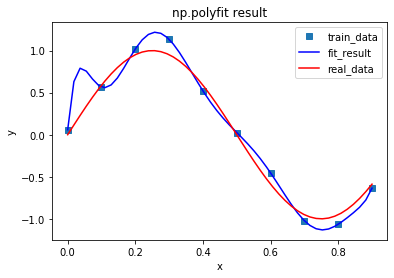

          9             8             7             6             5
3.14e+04 x - 1.377e+05 x + 2.537e+05 x - 2.544e+05 x + 1.503e+05 x
             4             3        2
 - 5.28e+04 x + 1.055e+04 x - 1081 x + 47.76 x + 0.05853


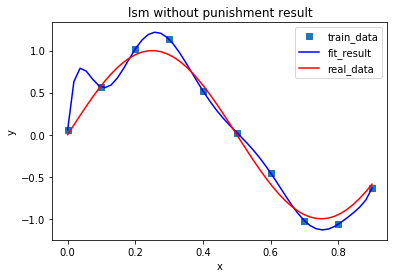

           9             8             7             6             5
3.139e+04 x - 1.377e+05 x + 2.536e+05 x - 2.543e+05 x + 1.503e+05 x
              4             3        2
 - 5.279e+04 x + 1.055e+04 x - 1081 x + 47.75 x + 0.0583


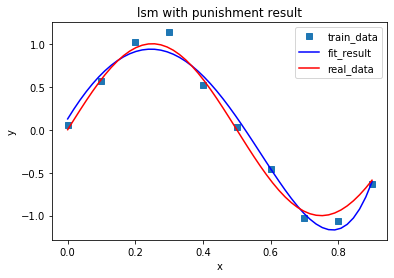

        9          8         7         6         5         4         3
-1.424 x + 0.3344 x + 2.215 x + 3.788 x + 4.172 x + 1.884 x - 4.523 x
          2
 - 11.84 x + 6.438 x + 0.1255


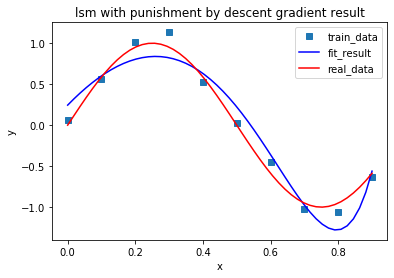

       9         8         7        6          5         4         3
2.633 x + 2.661 x + 2.466 x + 1.88 x + 0.6543 x - 1.491 x - 4.503 x
          2
 - 6.292 x + 4.246 x + 0.2443


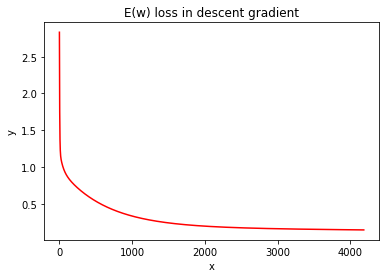

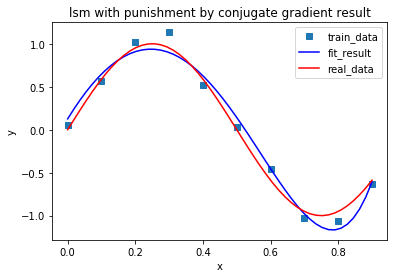

        9          8         7         6         5         4         3
-1.424 x + 0.3344 x + 2.215 x + 3.788 x + 4.172 x + 1.884 x - 4.523 x
          2
 - 11.84 x + 6.438 x + 0.1255


In [24]:
train_x, train_y = genData(0, 0.1) # 获取数据
print(genMatrixX(train_x).T.dot(genMatrixX(train_x)))
# numpy.polyfit直接拟合
p1 = np_polyfit(train_x, train_y)
plt_show(train_x, p1, train_y, 'np.polyfit result')
print(p1)

# 不加惩罚项，导数=0
p2 = lsm_loss(train_x, train_y)
plt_show(train_x, p2, train_y, 'lsm without punishment result')
print(p2)

# 加惩罚项，导数=0
lam1 = 0.0005
p3 = lsm_punished_loss(train_x, train_y, lam1)
plt_show(train_x, p3, train_y, 'lsm with punishment result')
print(p3)

# 加惩罚项，梯度下降求loss最小值
lam2 = 0.0001
eta1 = 0.05
epoch1 = 1000000
eps1 = 1e-5
p4, epoch_list, loss_list = descent_gradient(train_x, train_y, lam2, epoch1, eta1, eps1)
plt_show(train_x, p4, train_y, 'lsm with punishment by descent gradient result')
print(p4)
# 输出loss图像
plt.plot(epoch_list, loss_list, 'r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('E(w) loss in descent gradient')
plt.show()

# 加惩罚项，共轭梯度法
lam3 = 0.0005
eps2 = 1e-5
p5 = conjugate_gradient(train_x, train_y, lam3, eps2)
plt_show(train_x, p5, train_y, 'lsm with punishment by conjugate gradient result')
print(p5)